In [1]:
#%matplotlib notebook
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
print_context_dict ={'text.usetex':True,
                     'text.latex.preamble':"\\usepackage{siunitx}\n \\usepackage{xfrac}",
                     'font.size':10,
                     'legend.fontsize':10,
                     'xtick.labelsize':10,
                     'ytick.labelsize':10,
                     'axes.labelsize':10,
                     'font.family':'serif',
                     'legend.labelspacing':0.1,
                     'axes.linewidth':0.5,
                     'xtick.major.width':0.2,
                     'ytick.major.width':0.2,
                     'xtick.major.width':0.5,
                     'ytick.major.width':0.5,
                     'figure.figsize':(5.906,5.906/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.906/2,5.906/2/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.53/2,2.96),#beamer
                     #'figure.figsize':(5.53/2*2,2.96*2),#beamer
                     'figure.dpi':100}
    #figsize=(5.53,2.96)#beamer 16:9
    #figsize=(3.69,2.96)#beamer 16:9
    #plot.rc('axes.formatter',use_locale=True) #german months
# must be manually set due to some matplotlib bugs
if print_context_dict['text.usetex']:
    #plt.rc('text.latex',unicode=True)
    plt.rc('text',usetex=True)
    plt.rc('text.latex',preamble="\\usepackage{siunitx}\n \\usepackage{xfrac}")


from sympy import *
import sympy.plotting.experimental_lambdify
init_printing()

In [2]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\sfrac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\sfrac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\sfrac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

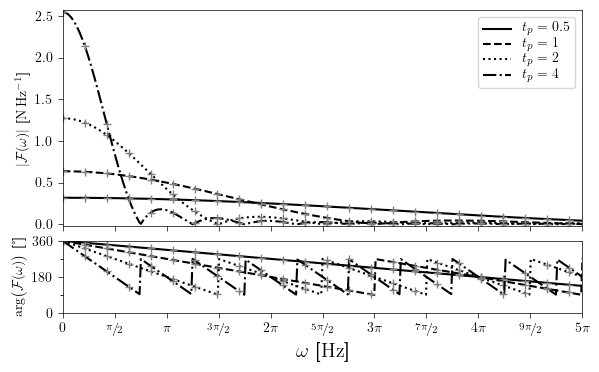

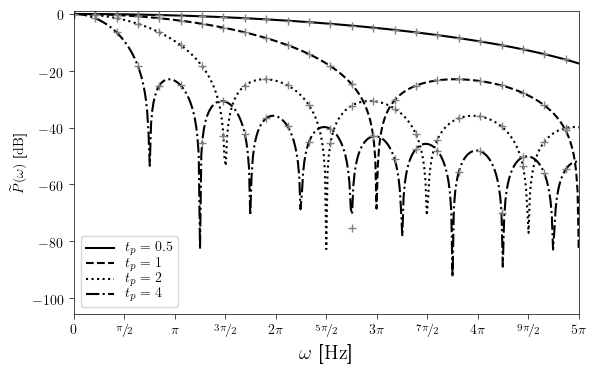

In [3]:
omega = np.linspace(0,20,500)
with matplotlib.rc_context(rc=print_context_dict):
    fig1,[ax,ax2]=plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, sharex=True)
    fig2,ax3=plt.subplots(1,1)

    t= np.linspace(0,3*np.pi,512)
    for ls_,tp in [('solid',.5), ('dashed',1), ('dotted',2), ('dashdot',4)]:
        pulse=np.sin(np.pi/tp*t)
        pulse[t>tp]=0
        fft=np.fft.rfft(pulse)
        deltat=t[1]-t[0]
        fft*=deltat
        fftfreq=np.fft.rfftfreq(pulse.shape[0],deltat)
        fftomega=fftfreq*2*np.pi
        psdn=fft*np.conj(fft)
        F=2*np.pi/tp*np.cos(tp*omega/2)/(np.pi**2/tp**2-omega**2)*np.exp(-1j*tp*omega/2)
        mag=np.abs(F)
        phase=np.angle(F)
        phase[phase<=0]+=2*np.pi
        psd=(2*np.pi/tp*np.cos(tp*omega/2)/(np.pi**2/tp**2-omega**2))**2/((2*np.pi/tp/(np.pi**2/tp**2)))**2
        psd=10*np.log10(psd)
        psdn=np.abs(fft)**2
        psdn /=psdn[0]
        psdn=10*np.log10(psdn)
        
        phasen=np.angle(fft)
        phasen[phasen<=0]+=2*np.pi
        ax.plot(omega, mag, ls=ls_, color='black', label=f'$t_p={tp}$')
        ax.plot(fftomega, np.abs(fft), marker='+', color='grey',ls='none')
        ax2.plot(omega, phase/np.pi*180, color='black',ls=ls_, label=f'$t_p={tp}$')
        ax2.plot(fftomega, phasen/np.pi*180, marker='+', color='grey',ls='none')
#         for i in range(10):
#             inds = np.logical_and(omega>i*2*np.pi/tp, omega<(i+1)*2*np.pi/tp)
#             if inds.any():
#                 print(tp,i)
#                 ax2.plot(omega[inds], phase[inds]/np.pi*180, ls=ls_, color='black',)
        ax3.plot(omega, psd, ls=ls_, color='black', label=f'$t_p={tp}$')
        #ax4.psd(pulse, Fs=1/(t[1]-t[0]),window=matplotlib.mlab.window_none,sides="onesided", label=f'$t_p={tp}$', NFFT=1024)
        ax3.plot(fftomega, psdn, marker='+', color='grey',ls='none')

    ax.set_xlim((0,5*np.pi))
    ax3.set_xlim((0,5*np.pi))
    ax2.set_ylim((0,360))

    #ax4.set_xlim((0,10/2/np.pi))
    #ax4.set_xlim((0,20))
    ax.legend()
    ax3.legend()
    
    
    ax2.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax.set_ylabel('$|\\mathcal{F}(\\omega)|$  [\\si{\\newton\\per\\hertz}]')
    ax2.set_ylabel('$\\arg\\bigl(\mathcal{F}(\omega)\\bigr)$ [\si{\degree}]')

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(180))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(90))
    ax3.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax3.set_ylabel('$\\widetilde{P}(\omega)$  [\si{\decibel}]')
    
    ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax3.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    
fig1.subplots_adjust(top=0.970, bottom=0.140, left=0.095, right=0.975, hspace=0.1)
#fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/fourier_transform_half_sine.pdf')
#fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/fourier_transform_half_sine.png')

fig2.subplots_adjust(top=0.970, bottom=0.140, left=0.120, right=0.975)

#fig2.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine.pdf')
#fig2.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine.png')

plt.show()

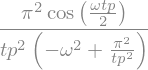

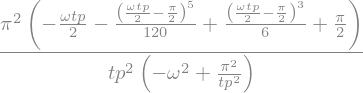

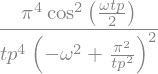

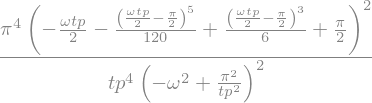

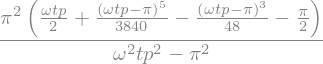

In [4]:
tp,omega = symbols('tp omega', real=True, positive=True)
f=-2*pi/tp*sin(tp*omega/2-pi/2)/(pi**2/tp**2-omega**2)
f0=f.subs(omega,0)
f=f/f0
P=f**2
Pdb=10*log(P,10)
#fexp=2*pi/tp*(1-(omega*tp/2)**2/2+(omega*tp/2)**4/24-(omega*tp/2)**6/720+(omega*tp/2)**8/40320-(omega*tp/2)**10/3628800)/(pi**2/tp**2-omega**2)
fexp=2*pi/tp*(-(omega*tp/2-pi/2) + (omega*tp/2-pi/2)**3/6 -(omega*tp/2-pi/2)**5/120)/(pi**2/tp**2-omega**2)
#fexp=2*pi/tp*(-(omega*tp/2-pi/2) + (omega*tp/2-pi/2)**3/6 )/(pi**2/tp**2-omega**2)
fexp=fexp/f0
Pexp=fexp**2
Pexpdb=10*log(Pexp,10)
#fexp=(pi**2*(1-(omega*tp/2)**2/2+(omega*tp/2)**4/24-(omega*tp/2)**6/720)/(tp**2*(pi**2/tp**2-omega**2)))**2
#fexp=(pi**2*(1-(omega*tp/2)**2/2+(omega*tp/2)**4/24)/(tp**2*(pi**2/tp**2-omega**2)))**2
#fexpdb=10*log(fexp)
display(f)
display(fexp)
display(P)
display(Pexp)
display(simplify(fexp))

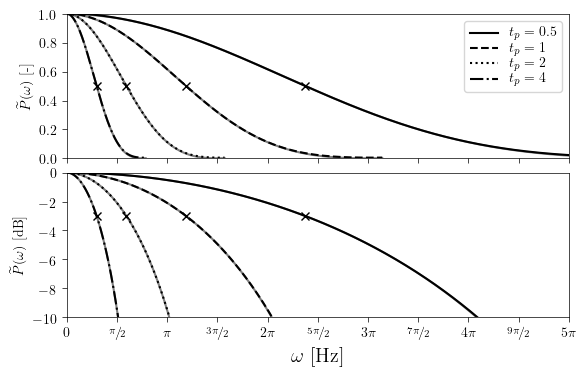

In [5]:
tps=np.linspace(0,10,101)[1:]
om3db=[]
omfact=[]

with matplotlib.rc_context(rc=print_context_dict):
    
    fig1,[ax1,ax2]=plt.subplots(2,1,sharex=True)
    for ls_,tp_ in [('solid',.5), ('dashed',1), ('dotted',2), ('dashdot',4)]:
        om3db.append(re(nsolve(Pdb.subs(tp,tp_)+3,3.72674844020097/tp_)))
        omfact.append(om3db[-1]*tp_)
        #omegas=np.linspace(1.1*np.pi/tp_,2*np.pi/tp_)
        if tp_ in [0.5,1,2,4]:
            omegas=np.linspace(0,np.pi**2/tp_,500)
            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],P.subs(tp,tp_))
            ax1.plot(omegas, exp(omegas), color='black',alpha=.5)
            ax1.plot([3.7291620893186/tp_],exp([3.7291620893186/tp_]), marker='x', color='black')

            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],Pexp.subs(tp,tp_))
            ax1.plot(omegas, exp(omegas), color='black', ls=ls_,label=f'$t_p={tp_}$')

            
            #print(exp([om3db[-1]]),exp([3.7291620893186/tp_]))

            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],Pdb.subs(tp,tp_))
            ax2.plot(omegas, exp(omegas),color='black',alpha=.5)
            ax2.plot([3.7291620893186/tp_],exp([3.7291620893186/tp_]), marker='x', color='black')

            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],Pexpdb.subs(tp,tp_))
            ax2.plot(omegas, exp(omegas), color='black', ls=ls_)

            
            #print(Pdb.subs(tp,tp_).subs(omega,om3db[-1]).evalf(),Pdb.subs(tp,tp_).subs(omega, 3.7291620893186/tp_).evalf())

    ax1.set_ylim((0,1))
    ax2.set_ylim((-10,0))
    #ax1.set_xlim((0,5*np.pi))
    ax2.set_xlim((0,5*np.pi))
    ax1.legend()
    #ax2.legend()
    
    
    #ax1.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax1.set_ylabel('$\\widetilde{P}(\omega)$  [-]')
    

    ax2.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax2.set_ylabel('$\\widetilde{P}(\omega)$  [\si{\decibel}]')
    
    ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    #ax1.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    #ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    
    fig1.subplots_adjust(top=0.970, bottom=0.140, left=0.125, right=0.975, hspace=0.1)
#     fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine_3db.pdf')
#     fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine_3db.png')

    plt.show()


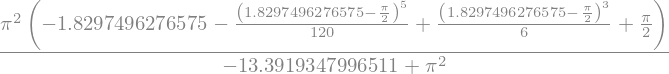

In [6]:
a=symbols('a')
omfacts_anal=solve(Eq(simplify(fexp),10**-(3/20)).subs((omega*tp), a))
display(omfacts_anal)
fexp.subs(omega, sqrt(omfacts_anal[1])/tp).subs(tp,1)

In [7]:
from sympy import *
f=tp*sinc(tp*omega/2)*exp(-1j*omega)
f/=f.subs(omega,0)
P=abs(f)

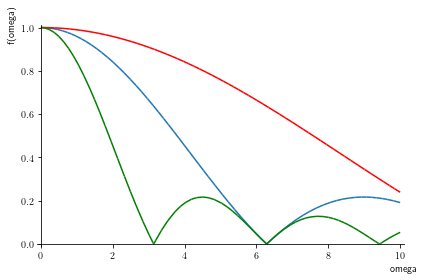

In [8]:
p1=plot(P.subs(tp,1),(omega,0,10), show=False)
p1.append(plot(abs(sinc(omega*tp/2)).subs(tp,0.5),(omega,0,10),line_color='red',show=False)[0])
p1.append(plot(abs((sin(omega*tp/2)/(omega*tp/2))).subs(tp,2), (omega,0,10), line_color='green',show=False)[0])
p1.show()

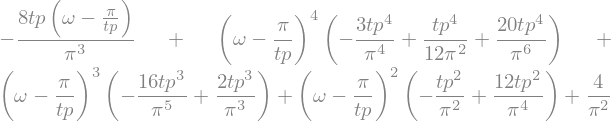

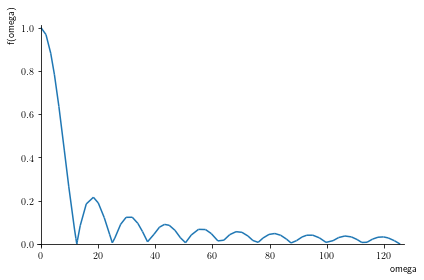

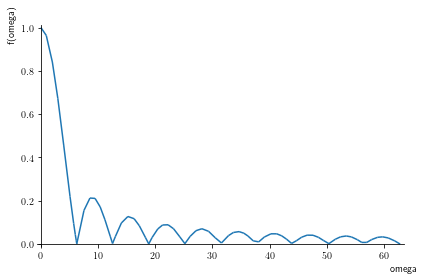

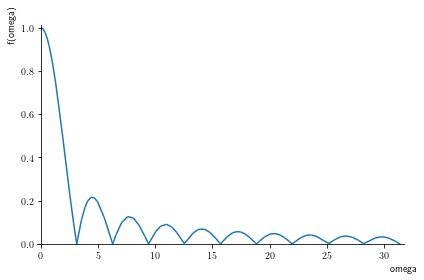

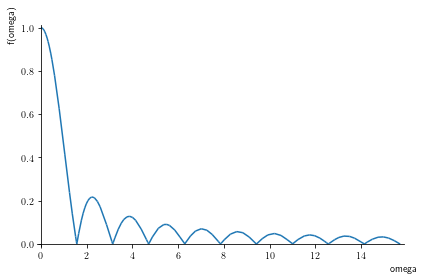

In [9]:
Pexp=series(((sin(omega*tp/2)/(omega*tp/2))**2),omega,pi/tp,5).removeO()
display(Pexp)
for ls_,tp_ in [('solid',.5), ('dashed',1), ('dotted',2), ('dashdot',4)]:
    
    p=plot(P.subs(tp,tp_),(omega,0,20*pi/tp_),show=False)
    #display(nsolve(P.subs(tp,tp_)-1/2,(pi/tp_).evalf())*tp_,display(nsolve(Pexp.subs(tp,tp_)-1/2,(pi/tp_).evalf())*tp_))
    #p.append(plot(Pexp.subs(tp,tp_),(omega,0,20*pi/tp_),line_color='red',show=False)[0])
    p.show()
#display(solve(Pexp-1/2,omega))

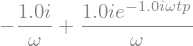

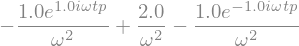

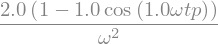

In [10]:
a,t,tp,omega=symbols('a t tp omega', real=True, positive=True)
Pomega=integrate(a*exp(-1j*omega*t),(t,0,tp)).subs(a,1)
display(Pomega)

mag=simplify(abs(Pomega))
display(abs(Pomega)**2)
display(mag**2)

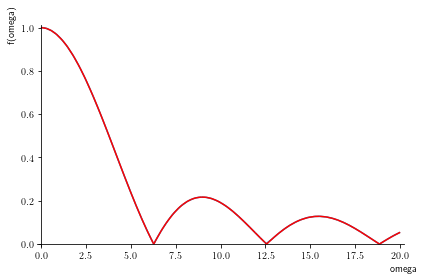

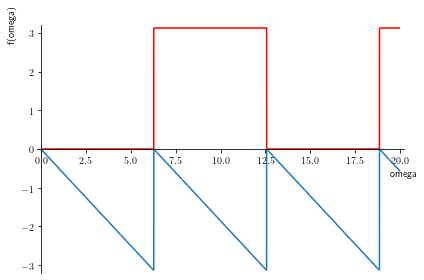

In [11]:
p1=plot(mag.subs(a,1).subs(tp,1),(omega,0,20), show=False)
p1.append(plot(abs((a*tp*sinc(omega*tp/2)).subs(a,1).subs(tp,1)),(omega,0,20),show=False,line_color='red')[0])
p1.show()
p2=plot(arg(Pomega).subs(a,1).subs(tp,1),(omega,0,20), show=False)
p2.append(plot(arg((a*tp*sinc(omega*tp/2)).subs(a,1).subs(tp,1)),(omega,0,20),show=False,line_color='red')[0])
p2.show()

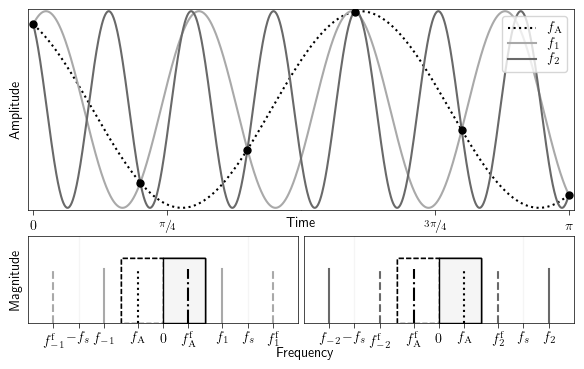

In [12]:
fs=10/(2*np.pi)
dur=np.pi
fa=0.3*fs
phia=2/3*np.pi
ca='black'
f1=0.7*fs
phi1=np.pi-phia
c1='darkgrey'
f2=1.3*fs
phi2=phia
c2='dimgray'
fit = lambda to,f,phi: np.sin(f*2*np.pi*to+phi)
#f2=0.55*fs
t=np.linspace(0,dur,1000,endpoint=True)
with matplotlib.rc_context(rc=print_context_dict):
    
    fig = plt.figure(constrained_layout=False, figsize=(5.906,5.906/1.618))
    gs1 = matplotlib.gridspec.GridSpec(nrows=3, ncols=2)
    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1], sharey=ax2)
    
    ax1.plot(t,fit(t,fa,phia),color=ca, ls='dotted', label='$f_\mathrm{A}$')
    ax1.plot(t,fit(t,f1,phi1), color=c1, ls='solid', label='$f_1$')
    ax1.plot(t,fit(t,f2,phi2), color=c2, ls='solid', label='$f_2$')
    t_=np.linspace(0,dur,int(dur*fs*1+1), endpoint=True)

    ax1.plot(t_,fit(t_,f2,phi2),ls='none',marker='.', markersize=10, color='black')
    ax1.xaxis.set_major_locator(plt.MultipleLocator(0.25*np.pi))
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(4)))
    ax1.set_yticks([])
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Time', backgroundcolor="white",labelpad=-12)
    ax1.legend(loc="upper right")
    # import scipy.optimize
    # popt,_=scipy.optimize.curve_fit(fit, t_, np.sin(f1*2*np.pi*t_), [f2,0])

    
#     f=np.linspace(-2.5*fs,2.5*fs,1000)    
    #fig, axes=plt.subplots(1,2, sharey=True, figsize=(5.906/2,5.906/1.618))
    axes=[ax2,ax3]
    for fact in [0,-fs,fs]:
        for ax in axes:
            ax.fill_between([-fs/2,-fs/2,0],[0,1.2,1.2,], facecolor='white', edgecolor='black', linestyle='dashed')
            ax.fill_between([0,fs/2,fs/2],[1.2,1.2,0], facecolor='whitesmoke', edgecolor='black', linestyle='solid')
            
    axes[0].plot([f1,f1],[0,1], color=c1, ls='solid')
    axes[0].plot([2*fs-f1,2*fs-f1],[0,1], color=c1, ls='dashed')
        
    axes[0].plot([-f1,-f1],[0,1], color=c1, ls='solid')
    axes[0].plot([-2*fs+f1,-2*fs+f1],[0,1], color=c1, ls='dashed')
    
    axes[0].plot([-fa,-fa],[0,1], color=ca, ls='dotted')
    axes[0].plot([fa,fa],[0,1], color=ca, ls='dashdot')
    
    axes[0].axvline(fs, color='whitesmoke', lw=1)
    axes[0].axvline(-fs, color='whitesmoke', lw=1)
    
    xticks=[-2*fs+f1              ,-fs     ,-f1       ,-fa               ,0 ,fa                             ,f1     ,fs     ,2*fs-f1]
    xlabels=['$f_{-1}^\mathrm{f}$','$-f_s$','$f_{-1}$','$f_{\mathrm{A}}$','$0$','$f_{\mathrm{A}}^\mathrm{f}$','$f_1$','$f_s$','$f_1^\mathrm{f}$']
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xlabels)
    
    
    axes[1].plot([f2,f2],[0,1], color=c2, ls='solid')
    axes[1].plot([2*fs-f2,2*fs-f2],[0,1], color=c2, ls='dashed')
        
    axes[1].plot([-f2,-f2],[0,1], color=c2, ls='solid')
    axes[1].plot([-2*fs+f2,-2*fs+f2],[0,1], color=c2, ls='dashed')
    
    axes[1].plot([fa,fa],[0,1], color=ca, ls='dotted')
    axes[1].plot([-fa,-fa],[0,1], color=ca, ls='dashdot')
    
    axes[1].axvline(fs, color='whitesmoke', lw=1)
    axes[1].axvline(-fs, color='whitesmoke', lw=1)
    
    xticks=[-2*fs+f2              ,-fs     ,-f2       ,fa               ,0 ,-fa                             ,f2     ,fs     ,2*fs-f2]
    xlabels=['$f_{-2}^\mathrm{f}$','$-f_s$','$f_{-2}$','$f_{\mathrm{A}}$','$0$','$f_{\mathrm{A}}^\mathrm{f}$','$f_2$','$f_s$','$f_2^\mathrm{f}$']
    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels(xlabels)
    axes[0].set_xlabel('Frequency')
    axes[0].xaxis.set_label_coords(1.03, -0.27)
    #axes[0].set_xlabel('Frequency')
    
    for ax in axes:
        ax.set_ylim((0,1.61))
        ax.set_xlim((-1.6*fs,1.6*fs))
        ax.set_yticks([])
    axes[0].set_ylabel('Magnitude')
    fig.subplots_adjust(top=0.970,bottom=0.11,left=0.045, right=0.97,wspace=0.02,hspace=0.3)
    #http://dspfirst.gatech.edu/chapters/04samplin/demos/aliasing/index.html
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/aliasing_folding.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/aliasing_folding.png')
    